*This notebook is recitation of a tutorial from Tensorflow site to get hands-on.*

The notes here are from the same [source](https://www.tensorflow.org/tutorials/images/transfer_learning)


In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A **pre-trained model** is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

In this notebook, you will try two ways to customize a pretrained model:

**Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

**Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg


### Data Preprocessing

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
## By default the file at the url origin is downloaded to the cache_dir ~/.keras,
## placed in the cache_subdir datasets, and given the filename fname

68606236/68606236 [==============================] - 1s 0us/step


In [3]:
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [4]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Check the shapes of the images and labels

In [6]:
for images, labels in train_dataset.take(1):
    print(images.shape)
    print(labels.shape)

(32, 160, 160, 3)
(32,)


In [7]:
# get all the class names
class_names =train_dataset.class_names
class_names

['cats', 'dogs']

0_cats


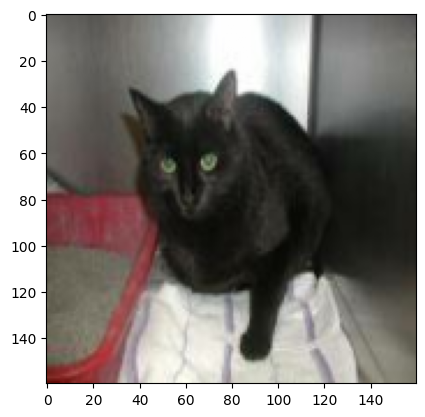

In [8]:
for images, labels in train_dataset.take(1):
    for i in range(1):
        plt.imshow(images[i]/255.)
        print(f"{labels[i]}_{class_names[labels[i]]}")

Show the first nine images and labels from the training set:

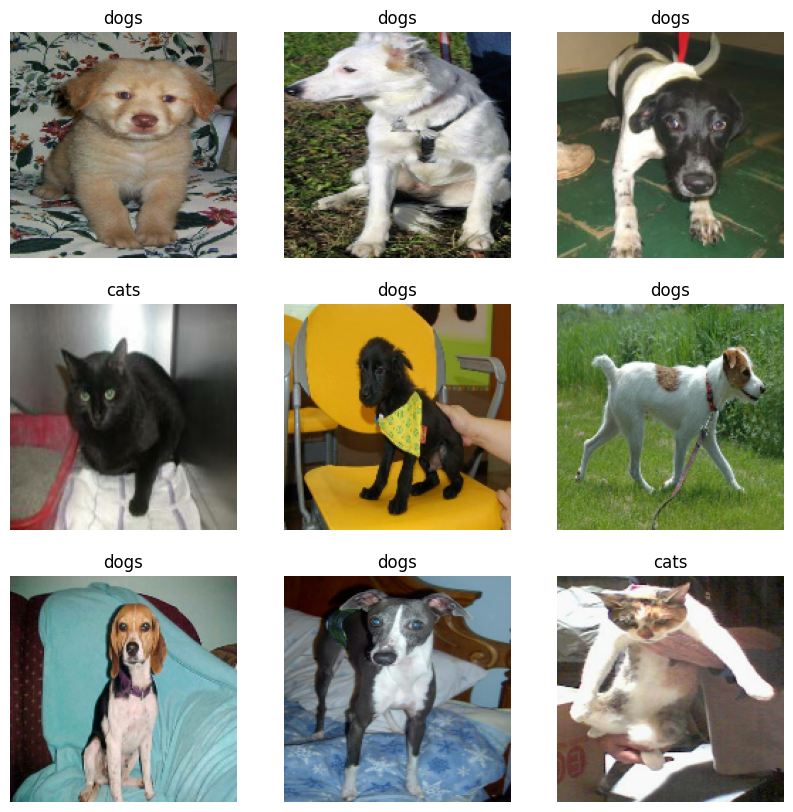

In [9]:
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis(False)

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=32>

In [11]:
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [12]:
len(test_dataset), len(validation_dataset)

(6, 26)

In [13]:
print(f"Number of batches in test: {tf.data.experimental.cardinality(test_dataset)}")
print(f"Number of batches in validation set: {tf.data.experimental.cardinality(validation_dataset)}")

Number of batches in test: 6
Number of batches in validation set: 26


Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

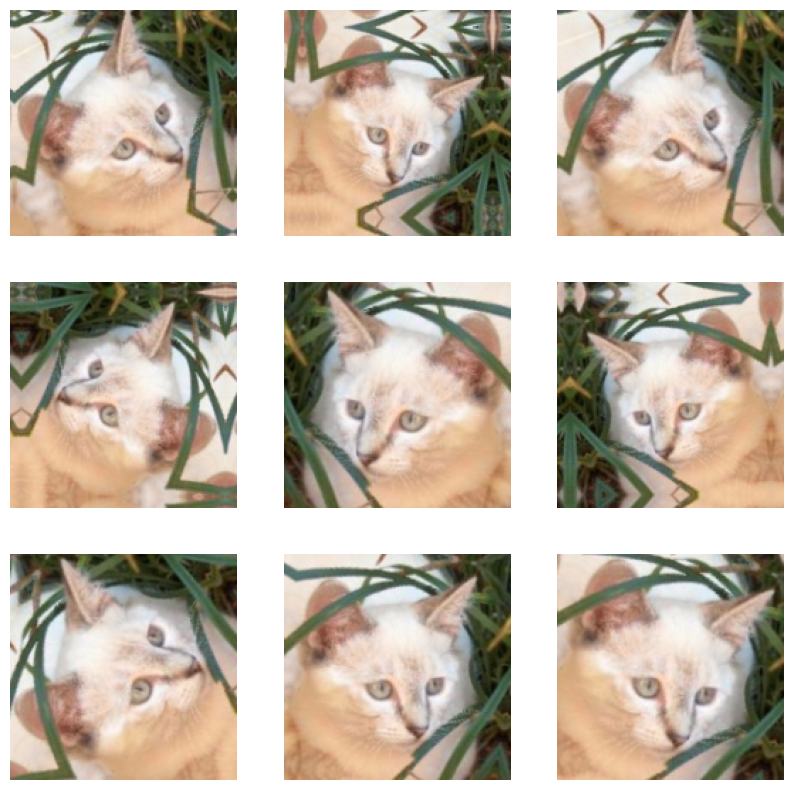

In [16]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    img = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(img, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis(False)

Rescale pixel values

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Optionally you can also use tf rescaling method


```
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
```



Create the base model from the pre-trained convnets

You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the **ImageNet dataset**, a large dataset consisting of` 1.4M images` and `1000 classes`. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the **"bottleneck layer"**. The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [18]:
# Create the base model

IMAGE_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


###Feature extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [20]:
base_model.trainable = False

Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [22]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(32, 1280)


Apply a` tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the *data augmentation, rescaling, base_model and feature extractor layers* using the **Keras Functional API**. As previously mentioned, use `training=False` as our model contains a BatchNormalization layer.

In [24]:
IMAGE_SHAPE

(160, 160, 3)

In [25]:
## Build the model

inputs = tf.keras.layers.Input(shape=IMAGE_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_avg_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [27]:
learning_rate = 0.0001
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               metrics=['accuracy'])

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [28]:
len(model.trainable_variables)

2

Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [29]:
initial_epochs=10

loss0,  accuracy0 = model.evaluate(validation_dataset)
loss0,  accuracy0

26/26 [==============================] - 5s 52ms/step - loss: 0.8450 - accuracy: 0.4839


(0.8450263738632202, 0.4839108884334564)

In [30]:
print(f"initial loss:{loss0:.2f}")
print(f"initial accuracy:{accuracy0:.2f}")

initial loss:0.85
initial accuracy:0.48


In [31]:
# Fit the model
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 10s 80ms/step - loss: 0.7902 - accuracy: 0.5300 - val_loss: 0.5791 - val_accuracy: 0.6559
Epoch 2/10
63/63 [==============================] - 4s 66ms/step - loss: 0.5800 - accuracy: 0.6620 - val_loss: 0.4182 - val_accuracy: 0.7896
Epoch 3/10
63/63 [==============================] - 6s 85ms/step - loss: 0.4454 - accuracy: 0.7630 - val_loss: 0.3240 - val_accuracy: 0.8540
Epoch 4/10
63/63 [==============================] - 6s 86ms/step - loss: 0.3785 - accuracy: 0.8145 - val_loss: 0.2658 - val_accuracy: 0.8787
Epoch 5/10
63/63 [==============================] - 5s 68ms/step - loss: 0.3443 - accuracy: 0.8405 - val_loss: 0.2201 - val_accuracy: 0.9171
Epoch 6/10
63/63 [==============================] - 6s 85ms/step - loss: 0.2977 - accuracy: 0.8675 - val_loss: 0.1961 - val_accuracy: 0.9183
Epoch 7/10
63/63 [==============================] - 4s 66ms/step - loss: 0.2854 - accuracy: 0.8715 - val_loss: 0.1743 - val_accuracy: 0.9196
Epoch 8/10
6

Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

Text(0.5, 1.0, 'Training and Validation Loss')

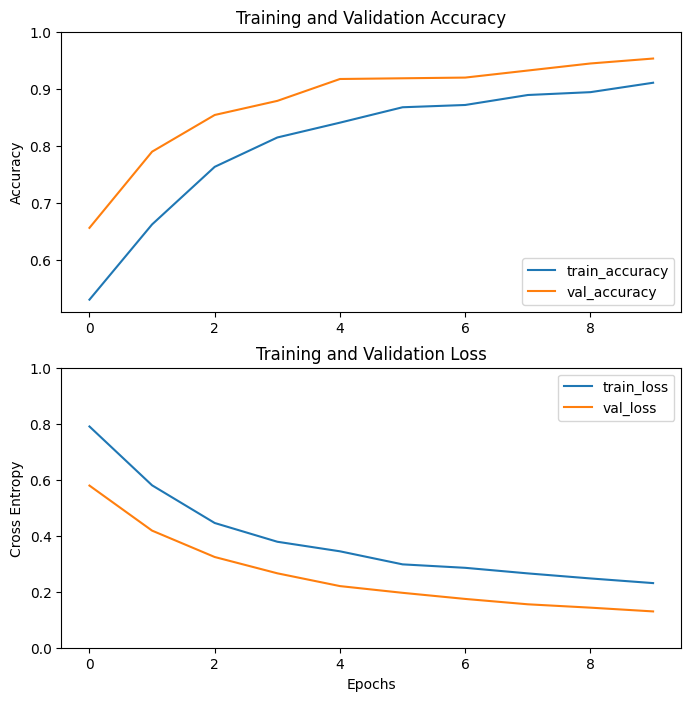

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim(min(plt.ylim()), 1)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.title('Training and Validation Loss')



*Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.*

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

*Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.*

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [33]:
base_model.trainable = True

In [34]:
# Lets see how many layers are there in basemodel
print(f"Number of layers in base model is: {len(base_model.layers)}")

Number of layers in base model is: 154


In [35]:
# Fine tune with this layer onwards
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable=False

Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [38]:
len(model.trainable_variables)

56

Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [39]:
fine_tune_epochs=10
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = model.fit(train_dataset,
                              epochs=total_epochs,
                              validation_data=validation_dataset,
                              initial_epoch=history.epoch[-1],
                              )

Epoch 10/20
63/63 [==============================] - 24s 91ms/step - loss: 0.1705 - accuracy: 0.9285 - val_loss: 0.0626 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 6s 84ms/step - loss: 0.1430 - accuracy: 0.9420 - val_loss: 0.0597 - val_accuracy: 0.9703
Epoch 12/20
63/63 [==============================] - 5s 72ms/step - loss: 0.1289 - accuracy: 0.9435 - val_loss: 0.0552 - val_accuracy: 0.9777
Epoch 13/20
63/63 [==============================] - 6s 92ms/step - loss: 0.1275 - accuracy: 0.9480 - val_loss: 0.0424 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 5s 73ms/step - loss: 0.1063 - accuracy: 0.9520 - val_loss: 0.0426 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 6s 91ms/step - loss: 0.1012 - accuracy: 0.9560 - val_loss: 0.0371 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 5s 73ms/step - loss: 0.0902 - accuracy: 0.9620 - val_loss: 0.0390 - val_accuracy: 0.9839
Epoch

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.

After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [40]:
acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']

loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']

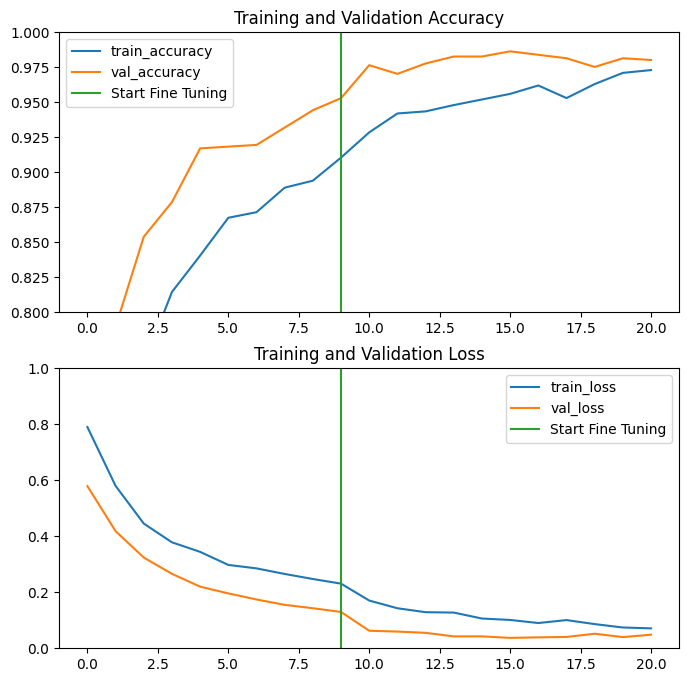

In [43]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [44]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy}")

6/6 [==============================] - 1s 48ms/step - loss: 0.0944 - accuracy: 0.9531
Test Accuracy: 0.953125


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0]
Labels:
[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0]


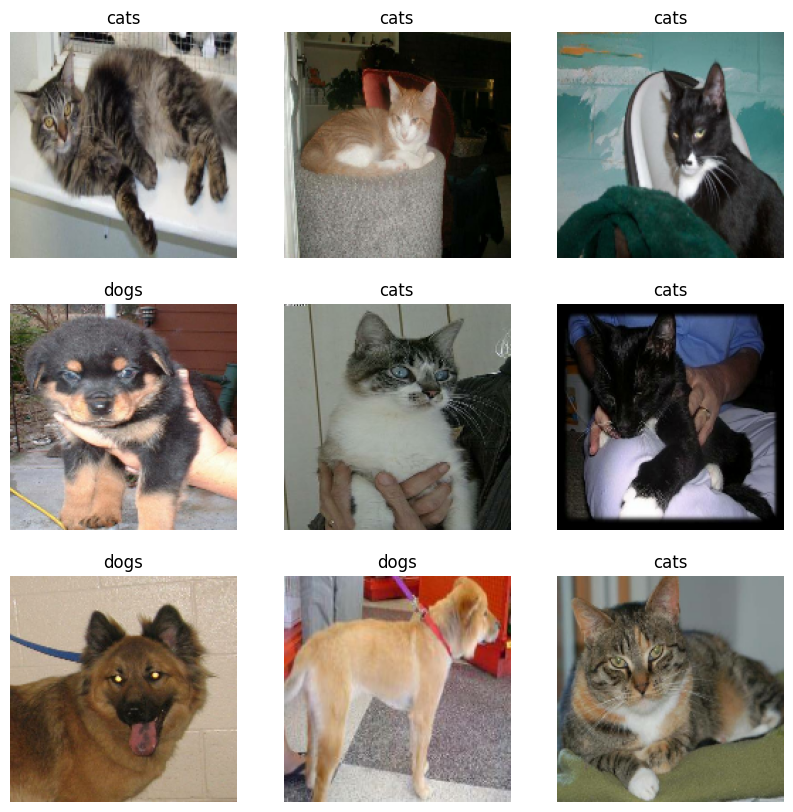

In [46]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions<0.5, 0, 1)

print(f"Predictions:\n{predictions.numpy()}")
print(f"Labels:\n{label_batch}")

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(class_names[predictions[i]])
  plt.axis('off')

## Summary
Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.